### Showing the direct relationship between tokens in descriptions and funding, based on Ridge model coefficients.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import numpy as np
import re
import pandas as pd

In [3]:
file_path = "data/full_imputed_linkedin.pkl"
data = pd.read_pickle(file_path)


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import nltk
from nltk.stem import WordNetLemmatizer
# Uncomment these lines if running for the first time
# nltk.download('wordnet')
# nltk.download('omw-1.4')

df = data
# Combine slogan and description for text analysis
df["text"] = df["description"].fillna("")

# Apply lemmatization on the text
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = text.split()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized)

df["text"] = df["text"].apply(lemmatize_text)

# Use TF-IDF to extract important words
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000,strip_accents='unicode')
X_text = vectorizer.fit_transform(df["text"])

# Train a Ridge regression model to predict funding
y_funding = df["funding"]
model = Ridge()
model.fit(X_text, y_funding)

# Predict funding using the trained model
y_pred = model.predict(X_text)

# Calculate the R2 score
r2 = r2_score(y_funding, y_pred)
print(f"R2 score: {r2}")

# Get feature importance (word impact on funding)
word_importance = dict(zip(vectorizer.get_feature_names_out(), model.coef_))

# Sort words by importance
top_words = sorted(word_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Convert to DataFrame for visualization
top_words_df = pd.DataFrame(top_words, columns=["Word", "Importance"])

R2 score: 0.018396168914260214


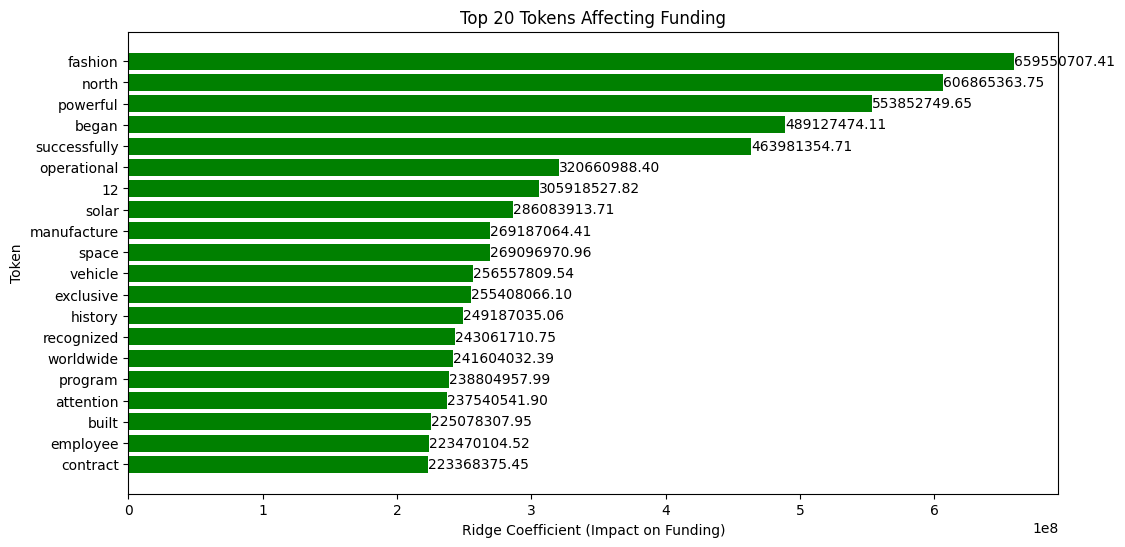

In [26]:
# Bar Chart: Top Tokens Affecting Funding
top_20 = top_words_df.head(20)
plt.figure(figsize=(12, 6))
plt.barh(top_20["Word"], top_20["Importance"], color=["green" if i > 0 else "red" for i in top_20["Importance"]])
plt.xlabel("Ridge Coefficient (Impact on Funding)")
plt.ylabel("Token")
plt.title("Top 20 Tokens Affecting Funding")
plt.gca().invert_yaxis()

# Annotate bars with values
for index, value in enumerate(top_20["Importance"]):
    plt.text(value, index, f"{value:.2f}", va="center")
plt.show()

#### How to Read It:
- Green bars → Words that increase funding.
- Red bars → Words that decrease funding.
- The further from zero, the stronger the impact.
- The black vertical line separates positive and negative effects.


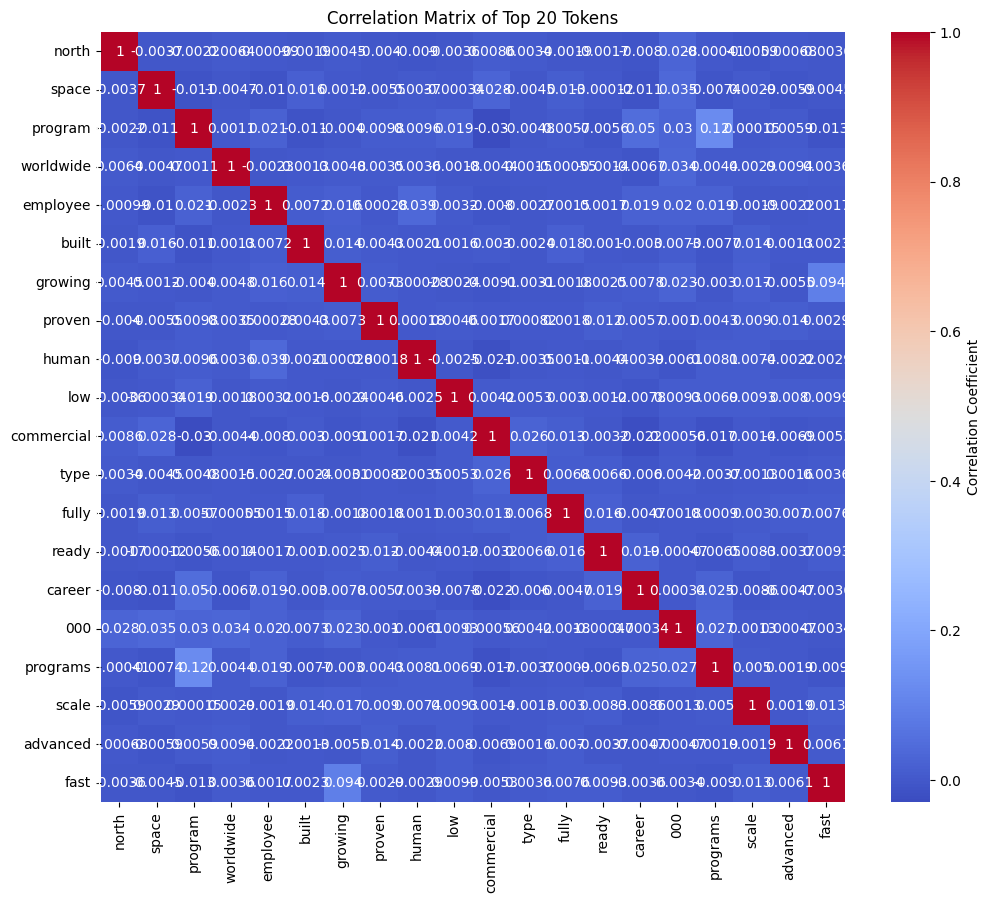

In [23]:
# Correlation Heatmap for Top 20 Tokens by Impact
top_20_tokens = top_words_df.head(20)["Word"].tolist()
token_indices = [list(vectorizer.get_feature_names_out()).index(word) for word in top_20_tokens]

tfidf_dense = X_text.toarray()
correlation_matrix = np.corrcoef(tfidf_dense[:, token_indices].T)

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    xticklabels=top_20_tokens,
    yticklabels=top_20_tokens,
    cbar_kws={"label": "Correlation Coefficient"}
)
plt.title("Correlation Matrix of Top 20 Tokens")
plt.show()


### Correlation Matrix of Top 20 Tokens

This heatmap visualizes the **correlation matrix of the top 20 tokens** based on their importance (as identified through TF-IDF or Ridge regression).

#### What It Shows:
1. **Correlation Coefficient:**
   - The values in the heatmap range between `-1` and `1`, indicating how strongly two tokens are related:
     - **1 (Red):** Strong positive correlation (tokens tend to occur together in the same context).
     - **0 (White):** No correlation (tokens are independent of each other).
     - **-1 (Blue):** Strong negative correlation (tokens tend to appear in opposing contexts).

2. **Axes:**
   - The tokens (e.g., "power," "storage," "energy") are listed along both the x-axis and y-axis.
   - Each cell represents the correlation between a pair of tokens.

3. **Color Gradient:**
   - Darker red indicates a stronger positive relationship.
   - Darker blue indicates a stronger negative relationship.
   - Light colors near white represent weak or no correlation.

- **Strong Positive Correlations:**
  - Tokens like **"energy" and "storage"** show a relatively strong correlation, suggesting they frequently co-occur in the same descriptions.
  - Words like **"leader" and "leading"** are also positively related.

- **Weak Correlations:**
  - Many token pairs have weak correlations (near 0), indicating that their appearances in the text are largely independent.

- **Negligible Negative Correlations:**
  - There are very few significant negative correlations (blue regions are rare).


1. **Co-Occurrence Analysis:**
   - The heatmap highlights how certain words are grouped together in company descriptions. For instance, **"energy" and "storage"** might be a theme for clean energy startups.

2. **Identifying Patterns:**
   - It helps detect themes or linguistic clusters in high-impact tokens, potentially revealing insights about how companies position themselves in successful funding pitches.

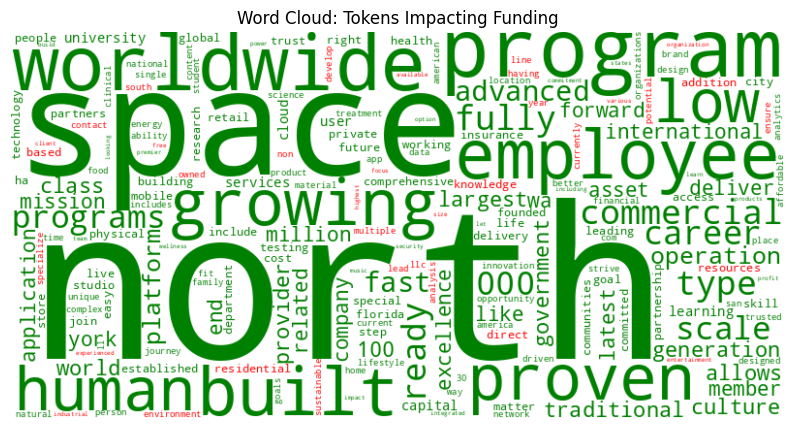

In [24]:
# Word Cloud: Impact of Words
word_impact_dict = {word: abs(impact) for word, impact in word_importance.items()}
color_func = lambda word, **kwargs: "green" if word_importance[word] > 0 else "red"

wordcloud = WordCloud(
    width=800, height=400,
    background_color="white",
    random_state=42,
    color_func=color_func
).generate_from_frequencies(word_impact_dict)

# Plot the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Tokens Impacting Funding")
plt.show()


#### What It Shows:
- Word Size:   <br/> 
    - Larger words, like "storage", "power", and "energy", have the greatest impact (positive or negative) on funding predictions. <br/>
    - Smaller words, like "independent" or "strategy", have less influence.
- Word Colors: <br/>
    - Green positive impact and red negative impact on funding predictions

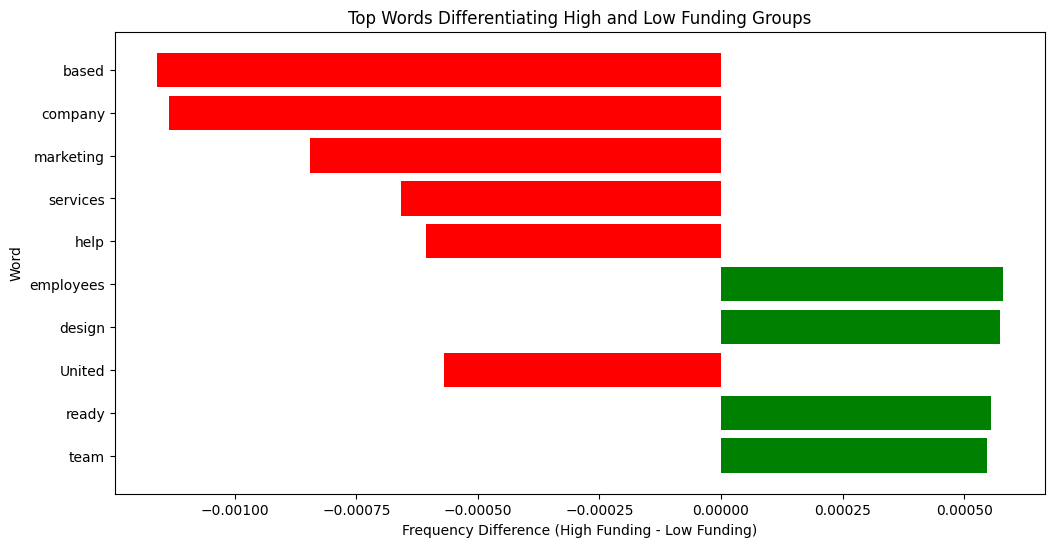

In [15]:
# Analyze word frequencies in high vs. low funding groups
symbols_to_remove = {"&", "-", "•"}

def filter_valid_words(text):
    return " ".join([
        word for word in text.split()
        if word.lower() not in ENGLISH_STOP_WORDS and word not in symbols_to_remove and re.match(r'^[a-zA-Z]+$', word)
    ])

# Filter and count word frequencies
high_funding = df[df["funding"] > df["funding"].median()]
low_funding = df[df["funding"] <= df["funding"].median()]

high_words = Counter(" ".join(high_funding["description"].dropna().apply(filter_valid_words)).split())
low_words = Counter(" ".join(low_funding["description"].dropna().apply(filter_valid_words)).split())

high_total = sum(high_words.values())
low_total = sum(low_words.values())

# Compute frequency differences
common_words = set(high_words.keys()).intersection(set(low_words.keys()))
frequency_difference = {
    word: (high_words[word] / high_total) - (low_words[word] / low_total)
    for word in common_words
}

# Sort by absolute difference
sorted_diff = sorted(frequency_difference.items(), key=lambda x: abs(x[1]), reverse=True)[:10]

# Plot Top Words by Frequency Difference
diff_words, diff_values = zip(*sorted_diff)
plt.figure(figsize=(12, 6))
plt.barh(diff_words, diff_values, color=["green" if v > 0 else "red" for v in diff_values])
plt.xlabel("Frequency Difference (High Funding - Low Funding)")
plt.ylabel("Word")
plt.title("Top Words Differentiating High and Low Funding Groups")
plt.gca().invert_yaxis()
plt.show()

#### What It Represents:

1. **X-Axis (Frequency Difference):**
    - Represents the difference in relative frequencies of each word between high-funding and low-funding groups. <br/>
    - Positive values (green bars) indicate words that are more common in high-funding descriptions. <br/>
    - Negative values (red bars) indicate words that are more common in low-funding descriptions. <br/>

2. **Y-Axis (Words):**
    - Lists the top words with the largest frequency differences between the two groups.
3. **Colors:**
    - Green bars: Words strongly associated with high funding.
    - Red bars: Words strongly associated with low funding.


- Words like "management" and "including" are more frequently used in descriptions of high-funding companies. <br/>
- Words like "marketing," "help," and "commercial" appear more frequently in descriptions of low-funding companies. <br/>
- The chart highlights the linguistic differences in how companies describe themselves in relation to their funding success. <br/>

- Helps identify which words or themes are positively or negatively correlated with funding. <br/>